In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import pandas as pd
import numpy as np
from xml.etree import ElementTree
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, Reshape, Activation, Flatten
from tensorflow.keras import layers, models
from keras.callbacks import ModelCheckpoint, TensorBoard
import tensorflow.keras.backend as K


import cv2


2023-05-06 16:24:05.547152: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-06 16:24:05.573324: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 16:24:05.942339: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
xmls_dir = '/home/jeffreydhy/data/projects/ares-finance/generated/images/labeled/AMD_30min_segments'
images_dir = '/home/jeffreydhy/data/projects/ares-finance/generated/images/unlabeled/AMD_30min_segments'

## Batch Data Generation

In [3]:
def xmls_to_dataframe(xmls_dir, images_dir):
    data = []
    for xml_filename in os.listdir(xmls_dir):
        # Read the XML file
        xml_path = os.path.join(xmls_dir, xml_filename)
        tree = ElementTree.parse(xml_path)
        root = tree.getroot()

        # Extract the bounding box coordinates
        bndbox = root.find(".//bndbox")
        xmin = float(bndbox.find("xmin").text)
        ymin = float(bndbox.find("ymin").text)
        xmax = float(bndbox.find("xmax").text)
        ymax = float(bndbox.find("ymax").text)
        size = root.find(".//size")
        height = float(size.find("height").text)
        width = float(size.find("width").text)

        # Add the image file path and bounding box coordinates to the DataFrame
        image_filename = os.path.splitext(xml_filename)[0] + ".png"
        image_path = os.path.join(images_dir, image_filename)
        data.append([image_path, xmin, ymin, xmax, ymax, height, width])

    return pd.DataFrame(data, columns=["image_path", "xmin", "ymin", "xmax", "ymax", "height", "width"])

# Normalize Bounding Boxes
def preprocess_bounding_boxes(data_df, input_shape):
    img_height, img_width, _ = input_shape

    for idx, row in data_df.iterrows():
        # Read original image dimensions
        original_height, original_width = row["height"], row["width"]

        # Calculate scaling factors
        width_scale = img_width / original_width
        height_scale = img_height / original_height

        # Scale and normalize bounding box coordinates
        xmin = row["xmin"] * width_scale
        ymin = row["ymin"] * height_scale
        xmax = row["xmax"] * width_scale
        ymax = row["ymax"] * height_scale

        # Update the dataframe with the new coordinates
        data_df.at[idx, "xmin"] = xmin / img_width
        data_df.at[idx, "ymin"] = ymin / img_height
        data_df.at[idx, "xmax"] = xmax / img_width
        data_df.at[idx, "ymax"] = ymax / img_height

    return data_df

In [4]:
data_df = xmls_to_dataframe(xmls_dir, images_dir)
batch_size = 16
input_shape = (224, 224, 3)
data_df = preprocess_bounding_boxes(data_df, input_shape)
data_df['confidence'] = 1


In [5]:
train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=42)

In [6]:
# Create the ImageDataGenerator with data augmentation options
image_data_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=False)


train_generator = image_data_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='image_path',
    y_col=['xmin', 'ymin', 'xmax', 'ymax', 'confidence'],
    target_size=input_shape[:2],
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    seed=42,
)

val_generator = image_data_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='image_path',
    y_col=['xmin', 'ymin', 'xmax', 'ymax', 'confidence'],
    target_size=input_shape[:2],
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    seed=42,
)

Found 116 validated image filenames.
Found 30 validated image filenames.


### Visualize the data with bounding box

In [7]:
def visualize_image_bbox(image, bboxes):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    img_height, img_width, _ = image.shape

    for box in bboxes:
        x, y, x_max, y_max = box
        x *= img_width
        y *= img_height
        x_max *= img_width
        y_max *= img_height

        width = x_max - x
        height = y_max - y

        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# images_batch, bboxes_batch = next(train_generator)
# image_index = 0
# image = images_batch[image_index]
# bboxes = [bboxes_batch[image_index]]

# print("bboxes_batch shape:", bboxes_batch.shape)
# print("bboxes:", bboxes)

# visualize_image_bbox(image, bboxes)

### Inspect GPUs

In [8]:
# print("TensorFlow version:", tf.__version__)
# print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# gpus = tf.config.list_physical_devices('GPU')
# for gpu in gpus:
#     print("GPU:", gpu)

In [9]:
num_classes = 1

# Initialize the MirroredStrategy for multi-GPU training
# strategy = tf.distribute.MirroredStrategy()


base_model = ResNet50(weights='imagenet', include_top=False)

# Add a global average pooling layer followed by a dense layer with 4 output units
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(5, activation='linear')(x)
# Create the final model
model = Model(inputs=base_model.input, outputs=output)

def custom_loss(y_true, y_pred):
    # Calculate mean squared error for bounding box coordinates
    mse = K.mean(K.square(y_true[:, :4] - y_pred[:, :4]), axis=-1)

    # Calculate binary cross-entropy for the confidence score
    bce = K.binary_crossentropy(y_true[:, 4], K.sigmoid(y_pred[:, 4]))

    # Combine the losses
    return mse + bce

# Compile the model with Mean Squared Error loss and the Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.0001), loss=custom_loss)

# Print the model summary
model.summary()

2023-05-06 16:24:14.305821: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-06 16:24:14.342059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-06 16:24:14.342191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv5_block3_1_conv (Conv2D)   (None, None, None,   1049088     ['conv5_block2_out[0][0]']       
                                512)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block3_1_relu[0][0]']    
          

In [11]:
train_steps_per_epoch = len(train_df) // batch_size
val_steps_per_epoch = len(val_df) // batch_size

x, y = next(train_generator)
print(x.shape, y.shape)

(16, 224, 224, 3) (16, 5)


In [12]:
tensorboard = TensorBoard(
    log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch'
)

checkpoint = ModelCheckpoint(
    'model_weights_best.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=300,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[checkpoint, tensorboard],
    verbose=1
)

Epoch 1/300


2023-05-06 16:24:27.340073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-06 16:24:32.577576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-06 16:24:33.114291: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-06 16:24:33.115944: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x564a6779a370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-06 16:24:33.115963: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-05-06 16:24:33.11910

6/7 [========================>.....] - ETA: 0s - loss: 0.3613

2023-05-06 16:24:43.441704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 2.21566, saving model to model_weights_best.h5
7/7 [==============================] - 17s 335ms/step - loss: 0.3295 - val_loss: 2.2157
Epoch 2/300
7/7 [==============================] - ETA: 0s - loss: 0.1455
Epoch 2: val_loss did not improve from 2.21566
7/7 [==============================] - 0s 52ms/step - loss: 0.1455 - val_loss: 2.3137
Epoch 3/300
5/7 [====================>.........] - ETA: 0s - loss: 0.0721
Epoch 3: val_loss improved from 2.21566 to 1.88180, saving model to model_weights_best.h5
7/7 [==============================] - 1s 112ms/step - loss: 0.0690 - val_loss: 1.8818
Epoch 4/300
7/7 [==============================] - ETA: 0s - loss: 0.0468
Epoch 4: val_loss improved from 1.88180 to 1.55109, saving model to model_weights_best.h5
7/7 [==============================] - 1s 115ms/step - loss: 0.0468 - val_loss: 1.5511
Epoch 5/300
7/7 [==============================] - ETA: 0s - loss: 0.0459
Epoch 5: val_loss improved from 1.55109 to

7/7 [==============================] - ETA: 0s - loss: 0.0064
Epoch 78: val_loss did not improve from 0.56044
7/7 [==============================] - 0s 47ms/step - loss: 0.0064 - val_loss: 0.8161
Epoch 79/300
7/7 [==============================] - ETA: 0s - loss: 0.0054
Epoch 79: val_loss did not improve from 0.56044
7/7 [==============================] - 0s 45ms/step - loss: 0.0054 - val_loss: 0.8365
Epoch 80/300
7/7 [==============================] - ETA: 0s - loss: 0.0050
Epoch 80: val_loss did not improve from 0.56044
7/7 [==============================] - 0s 48ms/step - loss: 0.0050 - val_loss: 0.8079
Epoch 81/300
7/7 [==============================] - ETA: 0s - loss: 0.0067
Epoch 81: val_loss did not improve from 0.56044
7/7 [==============================] - 0s 49ms/step - loss: 0.0067 - val_loss: 0.8010
Epoch 82/300
7/7 [==============================] - ETA: 0s - loss: 0.0087
Epoch 82: val_loss did not improve from 0.56044
7/7 [==============================] - 0s 49ms/step - 

7/7 [==============================] - ETA: 0s - loss: 0.0043
Epoch 155: val_loss improved from 0.47763 to 0.45898, saving model to model_weights_best.h5
7/7 [==============================] - 1s 114ms/step - loss: 0.0043 - val_loss: 0.4590
Epoch 156/300
6/7 [========================>.....] - ETA: 0s - loss: 0.0050
Epoch 156: val_loss improved from 0.45898 to 0.44965, saving model to model_weights_best.h5
7/7 [==============================] - 1s 115ms/step - loss: 0.0050 - val_loss: 0.4496
Epoch 157/300
6/7 [========================>.....] - ETA: 0s - loss: 0.0018
Epoch 157: val_loss improved from 0.44965 to 0.42352, saving model to model_weights_best.h5
7/7 [==============================] - 1s 113ms/step - loss: 0.0019 - val_loss: 0.4235
Epoch 158/300
7/7 [==============================] - ETA: 0s - loss: 0.0019  
Epoch 158: val_loss improved from 0.42352 to 0.40832, saving model to model_weights_best.h5
7/7 [==============================] - 1s 116ms/step - loss: 0.0019 - val_loss:

Epoch 189/300
6/7 [========================>.....] - ETA: 0s - loss: 0.0065
Epoch 189: val_loss did not improve from 0.01920
7/7 [==============================] - 0s 48ms/step - loss: 0.0060 - val_loss: 0.0464
Epoch 190/300
7/7 [==============================] - ETA: 0s - loss: 0.0055
Epoch 190: val_loss did not improve from 0.01920
7/7 [==============================] - 0s 46ms/step - loss: 0.0055 - val_loss: 0.0273
Epoch 191/300
7/7 [==============================] - ETA: 0s - loss: 0.0042
Epoch 191: val_loss did not improve from 0.01920
7/7 [==============================] - 0s 47ms/step - loss: 0.0042 - val_loss: 0.0251
Epoch 192/300
7/7 [==============================] - ETA: 0s - loss: 0.0034
Epoch 192: val_loss did not improve from 0.01920
7/7 [==============================] - 0s 48ms/step - loss: 0.0034 - val_loss: 0.0260
Epoch 193/300
7/7 [==============================] - ETA: 0s - loss: 0.0040
Epoch 193: val_loss improved from 0.01920 to 0.01625, saving model to model_weig

Epoch 227/300
7/7 [==============================] - ETA: 0s - loss: 0.0013  
Epoch 227: val_loss did not improve from 0.00759
7/7 [==============================] - 0s 52ms/step - loss: 0.0013 - val_loss: 0.0105
Epoch 228/300
7/7 [==============================] - ETA: 0s - loss: 0.0011  
Epoch 228: val_loss did not improve from 0.00759
7/7 [==============================] - 0s 55ms/step - loss: 0.0011 - val_loss: 0.0137
Epoch 229/300
7/7 [==============================] - ETA: 0s - loss: 7.3213e-04
Epoch 229: val_loss did not improve from 0.00759
7/7 [==============================] - 0s 46ms/step - loss: 7.3213e-04 - val_loss: 0.0114
Epoch 230/300
7/7 [==============================] - ETA: 0s - loss: 8.0041e-04
Epoch 230: val_loss did not improve from 0.00759
7/7 [==============================] - 0s 48ms/step - loss: 8.0041e-04 - val_loss: 0.0132
Epoch 231/300
7/7 [==============================] - ETA: 0s - loss: 9.8591e-04
Epoch 231: val_loss did not improve from 0.00759
7/7 [==

7/7 [==============================] - 0s 49ms/step - loss: 0.0034 - val_loss: 0.0132
Epoch 266/300
7/7 [==============================] - ETA: 0s - loss: 0.0023  
Epoch 266: val_loss improved from 0.00635 to 0.00553, saving model to model_weights_best.h5
7/7 [==============================] - 1s 114ms/step - loss: 0.0023 - val_loss: 0.0055
Epoch 267/300
7/7 [==============================] - ETA: 0s - loss: 0.0026
Epoch 267: val_loss did not improve from 0.00553
7/7 [==============================] - 0s 49ms/step - loss: 0.0026 - val_loss: 0.0096
Epoch 268/300
7/7 [==============================] - ETA: 0s - loss: 0.0013  
Epoch 268: val_loss did not improve from 0.00553
7/7 [==============================] - 0s 47ms/step - loss: 0.0013 - val_loss: 0.0130
Epoch 269/300
7/7 [==============================] - ETA: 0s - loss: 9.5700e-04
Epoch 269: val_loss did not improve from 0.00553
7/7 [==============================] - 0s 47ms/step - loss: 9.5700e-04 - val_loss: 0.0074
Epoch 270/300


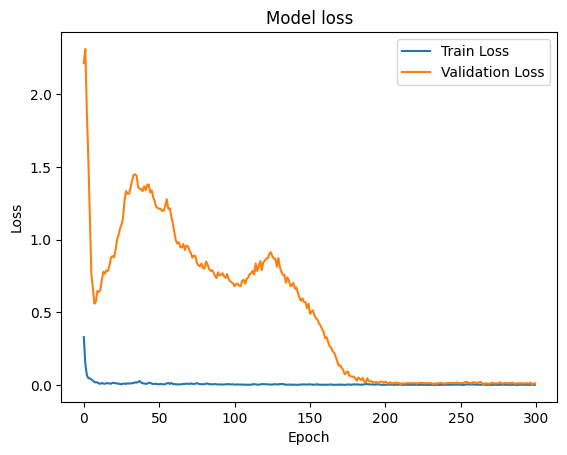

In [13]:
# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

### Use the model to predict

## test_image_path = '/home/jeffreydhy/data/projects/ares-finance/generated/images/unlabeled/AMD_30min_segments/segment_2023-04-21_53.png'
test_image = cv2.imread(test_image_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)


# Preprocess the test image
input_shape = (224, 224, 3)
resized_image = cv2.resize(test_image, input_shape[:2])
preprocessed_image = resized_image / 255.0
preprocessed_image = np.expand_dims(preprocessed_image, axis=0)

# Make a prediction
prediction = model.predict(preprocessed_image)[0]

# Post-process the prediction
xmin, ymin, xmax, ymax, prob = prediction
print("The possibility is {}".format(prob))
xmin = int(xmin * test_image.shape[1])
ymin = int(ymin * test_image.shape[0])
xmax = int(xmax * test_image.shape[1])
ymax = int(ymax * test_image.shape[0])

# Visualize the results
fig, ax = plt.subplots(1)
ax.imshow(test_image)
rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()